In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from pathlib import Path 
import glob
import os
from rdkit import DataStructs
import sys
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from rdkit.Chem import Draw, Descriptors, RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer as sa
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [42]:
path = 'data/balanced_data'
files = Path(path).glob('*.csv') 

In [43]:
all_files = glob.glob(os.path.join(path , "*.csv"))
frames = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    frames.append(df)
df = pd.concat(frames, axis=0, ignore_index=True)

In [44]:
df = df.drop_duplicates(subset = ['target'])
df = df[df.number_of_steps <= 10]
df = df[df.number_of_steps > 0]
df = df.reset_index(drop=True)
len(df) # 15918  

15918

<AxesSubplot:>

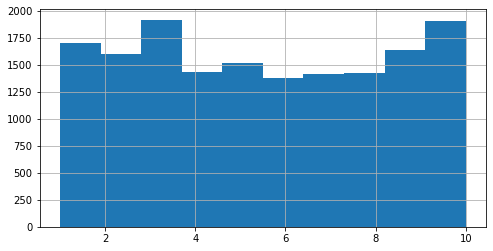

In [5]:
plt.figure(figsize=(8,4))
df.number_of_steps.hist() 

In [45]:
df['steps_bins'] = pd.cut(df['number_of_steps'], [0,1,3,6,10], labels=False) #, labels=False
df.steps_bins.value_counts()

3    6378
2    4324
1    3514
0    1702
Name: steps_bins, dtype: int64

In [7]:
#df['steps_bins2'] = pd.cut(df['number_of_steps'], [0,2,4,7,10], labels=False) #, labels=False
#df.steps_bins2.value_counts()

3    4964
2    4303
1    3351
0    3300
Name: steps_bins2, dtype: int64

In [7]:
sc = SCScorer()
sc.restore(os.path.join('/home/zumrovad/DP/scscore',
                        'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.json.gz'))
# (r'C:\Users\domiz\Documents\Python\DP\scscore', 'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.json.gz'))
sy = SybaClassifier()
sy.fitDefaultScore()

Restored variables from /home/zumrovad/DP/scscore/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz


In [46]:
syba = [sy.predict(smile) for smile in df.target]
df = df.assign(syba=syba)
sascore = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in df.target]
df = df.assign(sascore=sascore)
scscore = [sc.get_score_from_smi(smile)[1] for smile in df.target]
df = df.assign(scscore=scscore)

In [47]:
mols = [Chem.MolFromSmiles(m) for m in df.target]
df = df.assign(mol=mols)

In [48]:
df['MolWt'] = df.mol.apply(Descriptors.MolWt)
df['MolLogP'] = df.mol.apply(Descriptors.MolLogP)
df['NumHAccept'] = df.mol.apply(Descriptors.NumHAcceptors)
df['NumHDonors'] = df.mol.apply(Descriptors.NumHDonors)

<Figure size 1080x1080 with 0 Axes>

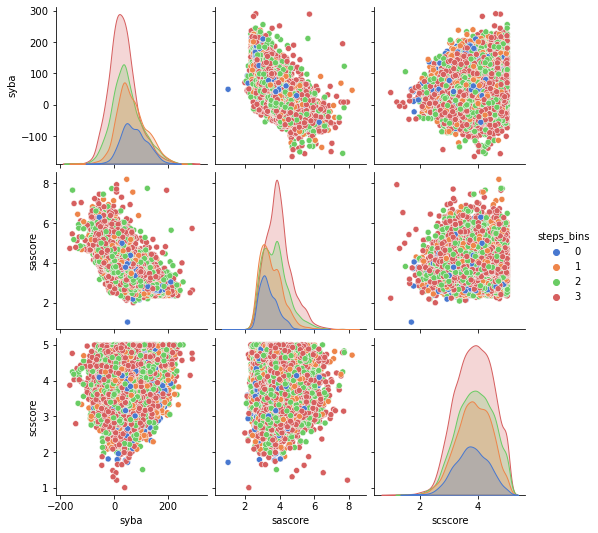

In [12]:
plt.figure(figsize=(15,15))
#sns.set_context("notebook", rc={"axes.labelsize": 16}) #"poster", font_scale=1.1
sns.pairplot(df[['steps_bins', 'syba', 'sascore', 'scscore']], hue='steps_bins', palette = 'muted') #height=2
#plt.savefig("set_context_notebook_Seaborn_pairplot.png", format='png',dpi=150)

In [195]:
filepath = Path('data/7Mfinal_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath, index=False) 

# Scaffold filter

In [11]:
#all_mols = [Chem.MolFromSmiles(smile) for smile in df.target]
#df['mol'] = all_mols
df["scaf1"] = df['mol'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaf2"] = df['scaf1'].apply(MurckoScaffold.MakeScaffoldGeneric)
df["scaf3"] = df['scaf2'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaf3_smiles"] = df['scaf3'].apply(Chem.MolToSmiles)

In [12]:
df_1 = df[df.number_of_steps == 1]
scaf_count_1 = df_1['scaf3_smiles'].value_counts()
scaf_count_1 = pd.DataFrame(scaf_count_1)
scaf_count_1['scaffold'] = scaf_count_1.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_1["prob"] = scaf_count_1["scaf3_smiles"].apply(lambda x: float(x)/len(df_1))

df_2 = df[df.number_of_steps <= 3]
df_2 = df_2[df_2.number_of_steps >= 2]
scaf_count_2 = df_2['scaf3_smiles'].value_counts()
scaf_count_2 = pd.DataFrame(scaf_count_2)
scaf_count_2['scaffold'] = scaf_count_2.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_2["prob"] = scaf_count_2["scaf3_smiles"].apply(lambda x: float(x)/len(df_2))

df_6 = df[df.number_of_steps <= 6]
df_6 = df_6[df_6.number_of_steps > 3]
scaf_count_6 = df_6['scaf3_smiles'].value_counts()
scaf_count_6 = pd.DataFrame(scaf_count_6)
scaf_count_6['scaffold'] = scaf_count_6.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_6["prob"] = scaf_count_6["scaf3_smiles"].apply(lambda x: float(x)/len(df_6))

df_10 = df[df.number_of_steps > 6]
scaf_count_10 = df_10['scaf3_smiles'].value_counts()
scaf_count_10 = pd.DataFrame(scaf_count_10)
scaf_count_10['scaffold'] = scaf_count_10.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_10["prob"] = scaf_count_10["scaf3_smiles"].apply(lambda x: float(x)/len(df_10))

In [13]:
smil0 = scaf_count_1.reset_index()
smil0['group'] = 0
smil1 = scaf_count_2.reset_index()
smil1['group'] = 1
smil2 = scaf_count_6.reset_index()
smil2['group'] = 2
smil3 = scaf_count_10.reset_index()
smil3['group'] = 3

In [14]:
def scaffold_filter(smil0, smil1, group0, group1, df):
    treshold_head = 1.7 # 1.5, 1.8, 2, 3,5
    treshold_tail = 0.59 # 0.67, 0.56, 0,5 0.33, 0.2
    scaffolds_merge = smil0.merge(smil1, left_on='index', right_on='index')
    scaffolds_merge["prob_ratio"] = scaffolds_merge['prob_x'] / scaffolds_merge['prob_y'] 
    scaffolds_merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)
    idx = []
    for i in scaffolds_merge[scaffolds_merge['prob_ratio'] < treshold_tail]['index']:
        ids = df.index[df.steps_bins == group0][df[df.steps_bins == group0].scaf3_smiles == i].tolist()
        for i in ids:
            idx.append(i)
    for i in scaffolds_merge[scaffolds_merge['prob_ratio'] > treshold_head]['index']:
        ids = df.index[df.steps_bins == group1][df[df.steps_bins == group1].scaf3_smiles == i].tolist()
        for i in ids:
            idx.append(i)
    return idx

In [15]:
df_new = df
df_new = df_new.drop(df_new.index[scaffold_filter(smil0, smil1, 0, 1, df)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil1, smil2, 1, 2, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil2, smil3, 2, 3, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil0, smil3, 0, 3, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil1, smil3, 1, 3, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil0, smil2, 0, 2, df_new)])

In [16]:
len(df) - len(df_new) # 2 1930 ; 1,5 2961
# 2492

2492

In [17]:
df_scaf = df_new

# Similarity filter

In [49]:
def similarity_search(df, f): 
    sim = [DataStructs.FingerprintSimilarity(x, f) for x in df.finger]
    return sim
def similarity(df):
    distance_matrix = []
    for i in range(0,len(df)):
        s = similarity_search(df, df.finger[i])
        distance_matrix.append(s)
    return distance_matrix
def group_similarity(df):
    mean = []
    std = []
    for fps in df.finger:
        a = similarity_search(df, fps)
        mean.append(np.mean(a))
        std.append(np.std(a))
    new_df = df.assign(mean = mean, std = std)
    return new_df

In [50]:
df_new = df
fingers = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in df_new.mol]
df_new['finger'] = fingers

In [51]:
df_0 = df_new[df_new.steps_bins == 0]
df_0 = df_0.reset_index(drop = True)
df_1 = df_new[df_new.steps_bins == 1]
df_1 = df_1.reset_index(drop = True)
df_2 = df_new[df_new.steps_bins == 2]
df_2 = df_2.reset_index(drop = True)
df_3 = df_new[df_new.steps_bins == 3]
df_3 = df_3.reset_index(drop = True)

In [52]:
df_0 = group_similarity(df_0)
df_1 = group_similarity(df_1)
df_2 = group_similarity(df_2)
df_3 = group_similarity(df_3)
frames = [df_0, df_1, df_2, df_3]
df_sim = pd.concat(frames, axis=0, ignore_index=True)

In [53]:
treshold = 0.11
#df_sim[df_sim['mean'] >= treshold]
ids = df_sim.index[df_sim['mean'] < treshold].tolist()
df_sim = df_sim.drop(df_sim.index[ids])

In [54]:
len(df_new) - len(df_sim) # with similarity filter
# 2811

3366

In [26]:
#df_both_filtrs = df_sim

# Test model

In [32]:
def cross_scoring(model, X, Y):
    score = {'r2':'r2',
         'MAE':'neg_mean_absolute_error',
         'MSE':'neg_mean_squared_error',
         'RMSE':'neg_root_mean_squared_error'}
    scores = cross_validate(model, X, Y, scoring=score, cv=10)
    return scores

In [33]:
def best_param(x,y):
    #RFR
    RFR = RandomForestRegressor(random_state=0)
    params = { 'max_depth': [8, 15, 20, None],
               'max_features': [1.0, 'sqrt'],
               'n_estimators': [200, 400, 800, 1000]}
    search = GridSearchCV(RFR, params, scoring='neg_mean_squared_error', cv=10)
    results_RFR = search.fit(x, y)
    return -results_RFR.best_score_, results_RFR.best_params_
    #print('Best MSE: %0.3f' % -results_RFR.best_score_)
    #print('Best Hyperparameters: %s' % results_RFR.best_params_)

In [55]:
len(df), len(df_scaf), len(df_sim), len(df_both_filtrs)

(15918, 13426, 12552, 10615)

### All generated data

In [28]:
y = np.array(df.steps_bins)
y_steps = np.array(df.number_of_steps)
x = np.array(df[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [383]:
score, params = best_param(x,y)
print('Best MSE: %0.3f' % score)
print('Best Hyperparameters: %s' % params)

Best MSE: 6.731
Best Hyperparameters: {'max_depth': 8, 'n_estimators': 200}


In [29]:
#RFR = RandomForestRegressor(random_state=0, max_depth=8, n_estimators=200)
RFR = RandomForestRegressor(random_state=0)

In [34]:
score_df = cross_scoring(RFR, x, y)
score_df_steps = cross_scoring(RFR, x, y_steps)

In [35]:
print("Groups")
print("MAE %0.3f (+/- %0.3f)" % (-score_df['test_MAE'].mean(), score_df['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df['test_MSE'].mean(), score_df['test_MSE'].std()))
print("Steps")
print("MAE %0.3f (+/- %0.3f)" % (-score_df_steps['test_MAE'].mean(), score_df_steps['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df_steps['test_MSE'].mean(), score_df_steps['test_MSE'].std()))

Groups
MAE 0.748 (+/- 0.049)
MSE 0.812 (+/- 0.102)
Steps
MAE 2.189 (+/- 0.022)
MSE 6.892 (+/- 0.123)


### After filter

In [36]:
# Scaffold filter
y_scaf = np.array(df_scaf.steps_bins)
y_scaf_steps = np.array(df_scaf.number_of_steps)
x_scaf = np.array(df_scaf[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [ ]:
s_new, p_new = best_param(x_scaf, y_scaf)
print('Best MSE: %0.3f' % s_new)
print('Best Hyperparameters: %s' % p_new)

In [59]:
#RFR = RandomForestRegressor(random_state=0, max_depth=8, n_estimators=250)
RFR = RandomForestRegressor(random_state=0)

In [37]:
score_df_scaf = cross_scoring(RFR, x_scaf, y_scaf)
score_df_scaf_steps = cross_scoring(RFR, x_scaf, y_scaf_steps)

In [38]:
print("Groups")
print("MAE %0.3f (+/- %0.3f)" % (-score_df_scaf['test_MAE'].mean(), score_df_scaf['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df_scaf['test_MSE'].mean(), score_df_scaf['test_MSE'].std()))
print("Steps")
print("MAE %0.3f (+/- %0.3f)" % (-score_df_scaf_steps['test_MAE'].mean(), score_df_scaf_steps['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df_scaf_steps['test_MSE'].mean(), score_df_scaf_steps['test_MSE'].std()))

Groups
MAE 0.724 (+/- 0.040)
MSE 0.772 (+/- 0.084)
Steps
MAE 2.098 (+/- 0.057)
MSE 6.474 (+/- 0.204)


In [56]:
# Similarity filter
y_sim = np.array(df_sim.steps_bins)
y_sim_steps = np.array(df_sim.number_of_steps)
x_sim = np.array(df_sim[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [57]:
score_df_sim = cross_scoring(RFR, x_sim, y_sim)
score_df_sim_steps = cross_scoring(RFR, x_sim, y_sim_steps)

In [58]:
print("Groups")
print("MAE %0.3f (+/- %0.3f)" % (-score_df_sim['test_MAE'].mean(), score_df_sim['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df_sim['test_MSE'].mean(), score_df_sim['test_MSE'].std()))
print("Steps")
print("MAE %0.3f (+/- %0.3f)" % (-score_df_sim_steps['test_MAE'].mean(), score_df_sim_steps['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df_sim_steps['test_MSE'].mean(), score_df_sim_steps['test_MSE'].std()))

Groups
MAE 0.894 (+/- 0.322)
MSE 1.119 (+/- 0.713)
Steps
MAE 2.512 (+/- 0.619)
MSE 8.707 (+/- 3.450)


In [39]:
# Similarity and scaffold filter
y_new = np.array(df_both_filtrs.steps_bins)
y_new_steps = np.array(df_both_filtrs.number_of_steps)
x_new = np.array(df_both_filtrs[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [40]:
score_df_new = cross_scoring(RFR, x_new, y_new)
score_df_new_steps = cross_scoring(RFR, x_new, y_new_steps)

In [41]:
print("Groups")
print("MAE %0.3f (+/- %0.3f)" % (-score_df_new['test_MAE'].mean(), score_df_new['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df_new['test_MSE'].mean(), score_df_new['test_MSE'].std()))
print("Steps")
print("MAE %0.3f (+/- %0.3f)" % (-score_df_new_steps['test_MAE'].mean(), score_df_new_steps['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df_new_steps['test_MSE'].mean(), score_df_new_steps['test_MSE'].std()))

Groups
MAE 0.856 (+/- 0.266)
MSE 1.034 (+/- 0.554)
Steps
MAE 2.389 (+/- 0.523)
MSE 8.064 (+/- 2.991)


## Prediction Denis data

In [290]:
df1 = pd.read_csv('data/Denis_final_data_after_pipeline.csv')
df1 = df1[df1.steps > 0]
df1 = df1[df1.steps <= 10]
df1 = df1.drop_duplicates(subset=['smiles'])
df1 = df1.drop(columns=['orig_smiles','orig_index','is_solved','pipeline_status','syba_score'])

In [293]:
mols1 = [Chem.MolFromSmiles(smile) for smile in df1.smiles]
df1['mol'] = mols1
df1['MolWt'] = df1.mol.apply(Descriptors.MolWt)
df1['MolLogP'] = df1.mol.apply(Descriptors.MolLogP)
df1['NumHAccept'] = df1.mol.apply(Descriptors.NumHAcceptors)
df1['NumHDonors'] = df1.mol.apply(Descriptors.NumHDonors)
df1['steps_bins'] = pd.cut(df1['steps'], [0,1,3,6,10], labels=False) #, labels=False

In [299]:
y1 = np.array(df1.steps_bins)
y1_steps = np.array(df1.steps)
x1 = np.array(df1[['syba', 'sa', 'sc', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [301]:
score_df1 = cross_scoring(RFR, x1, y1)
score_df1_steps = cross_scoring(RFR, x1, y1_steps)

In [302]:
print("r2 %0.3f (+/- %0.3f)" % (score_df1['test_r2'].mean(), score_df1['test_r2'].std()))
print("MAE %0.3f (+/- %0.3f)" % (-score_df1['test_MAE'].mean(), score_df1['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df1['test_MSE'].mean(), score_df1['test_MSE'].std()))
print("RMSE %0.3f (+/- %0.3f)" % (-score_df1['test_RMSE'].mean(), score_df1['test_RMSE'].std()))

r2 0.352 (+/- 0.072)
MAE 0.627 (+/- 0.078)
MSE 0.650 (+/- 0.108)
RMSE 0.803 (+/- 0.067)


In [303]:
print("r2 %0.3f (+/- %0.3f)" % (score_df1_steps['test_r2'].mean(), score_df1_steps['test_r2'].std()))
print("MAE %0.3f (+/- %0.3f)" % (-score_df1_steps['test_MAE'].mean(), score_df1_steps['test_MAE'].std()))
print("MSE %0.3f (+/- %0.3f)" % (-score_df1_steps['test_MSE'].mean(), score_df1_steps['test_MSE'].std()))
print("RMSE %0.3f (+/- %0.3f)" % (-score_df1_steps['test_RMSE'].mean(), score_df1_steps['test_RMSE'].std()))

r2 0.301 (+/- 0.065)
MAE 1.652 (+/- 0.362)
MSE 5.002 (+/- 1.451)
RMSE 2.213 (+/- 0.326)


# Comparison

## Steps

In [134]:
d1 = pd.DataFrame.from_dict(score_df_steps)
d1['data']='Control'
d2 = pd.DataFrame.from_dict(score_df_scaf_steps)
d2['data']='Scaffold\nfilter'
d3 = pd.DataFrame.from_dict(score_df_sim_steps)
d3['data']='Similarity\nfilter'
d4 = pd.DataFrame.from_dict(score_df_new_steps)
d4['data']='Similarity\n and\nscaffold filter'

In [135]:
frames = [d1, d2, d3, d4]
df_scores = pd.concat(frames)

In [136]:
df_scores['test_MSE'] = -1*df_scores['test_MSE']
df_scores['test_MAE'] = -1*df_scores['test_MAE']
df_scores['test_RMSE'] = -1*df_scores['test_RMSE']

Text(0.5, 48.5, ' ')

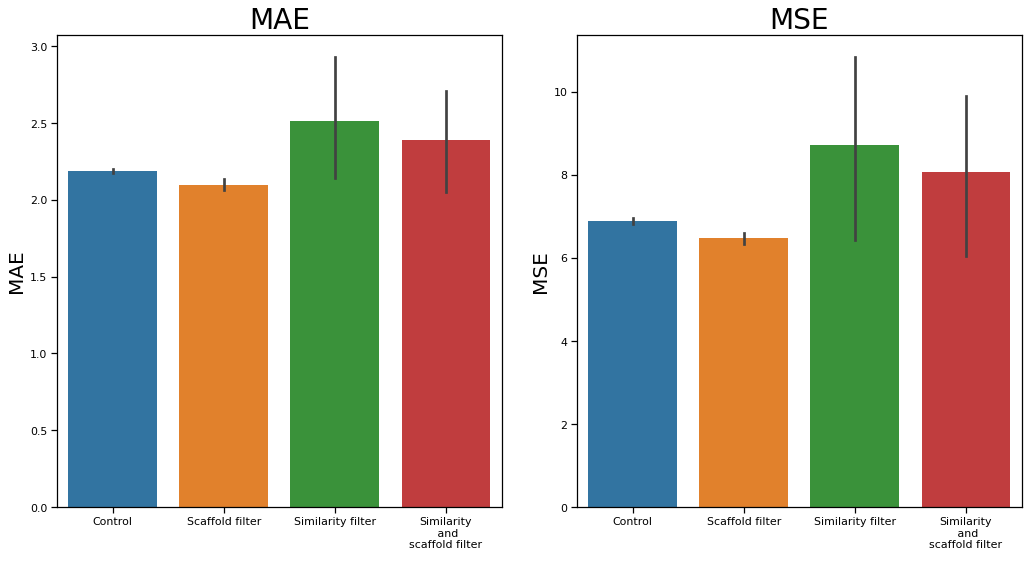

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.set_context("notebook", rc={"font.size":20,"axes.titlesize":18,"axes.labelsize":15}) 
fig.tight_layout(pad=2.0)
sns.barplot(ax=axes[0], data=df_scores, x="data", y="test_MAE")
axes[0].set_title('MAE', fontsize=28)
sns.barplot(ax=axes[1], data=df_scores, x="data", y="test_MSE")
axes[1].set_title('MSE', fontsize=28)
axes[0].set_ylabel('MAE',fontsize=20)
axes[0].set_xlabel(' ',fontsize=20)
axes[1].set_ylabel('MSE',fontsize=20)
axes[1].set_xlabel(' ',fontsize=20)

Text(0.5, 1.0, 'MSE')

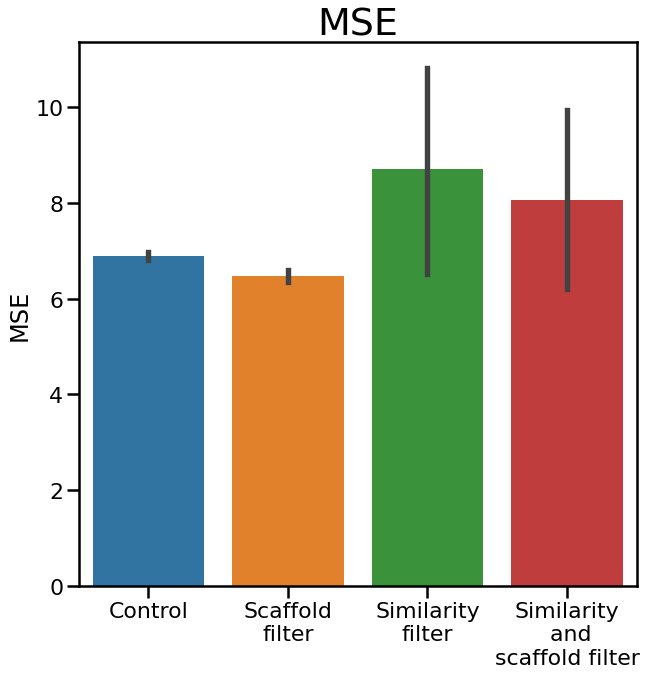

In [146]:
sns.set_context("poster", rc={"font.size":18, "axes.titlesize":18, "axes.labelsize":22}) 
plt.figure(figsize=(10,10))
g = sns.barplot(data=df_scores, x="data", y="test_MSE")
g.set_xlabel(' ',fontsize=16)
g.set_ylabel('MSE',fontsize=24)
g.set_title('MSE', fontsize=38)
#plt.xticks(size = 16)

In [147]:
fig = g.get_figure()
fig.savefig('mse_filters.png')

## Groups

In [131]:
d5 = pd.DataFrame.from_dict(score_df)
d5['data']='Control'
d6 = pd.DataFrame.from_dict(score_df_scaf)
d6['data']='Scaffold\nfilter'
d7 = pd.DataFrame.from_dict(score_df_sim)
d7['data']='Similarity\nfilter'
d8 = pd.DataFrame.from_dict(score_df_new)
d8['data']='Similarity\n and\nscaffold filter'

In [132]:
frames = [d5, d6, d7, d8]
df_scores2 = pd.concat(frames)
df_scores2['test_MSE'] = -1*df_scores2['test_MSE']
df_scores2['test_MAE'] = -1*df_scores2['test_MAE']
df_scores2['test_RMSE'] = -1*df_scores2['test_RMSE']

Text(0.5, 1.0, 'MSE')

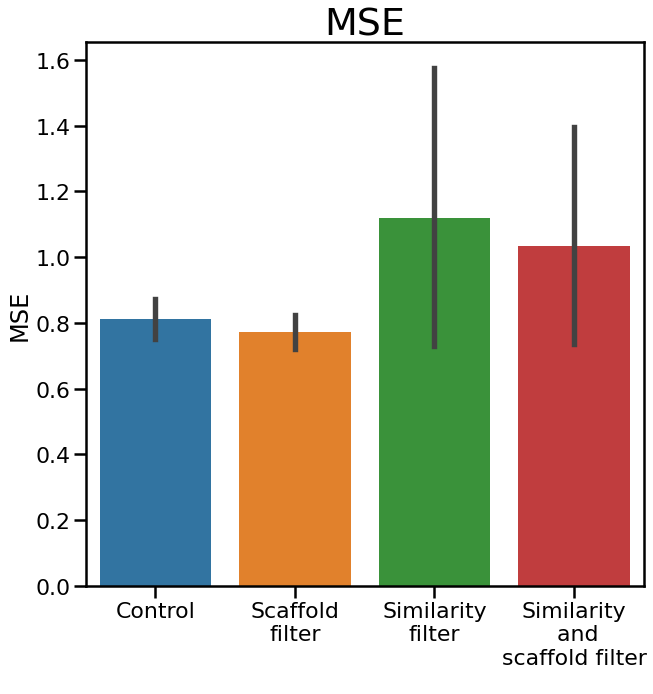

In [148]:
sns.set_context("poster", rc={"font.size":18, "axes.titlesize":18, "axes.labelsize":22}) 
plt.figure(figsize=(10,10))
g = sns.barplot(data=df_scores2, x="data", y="test_MSE")
g.set_xlabel(' ',fontsize=16)
g.set_ylabel('MSE', fontsize=24)
g.set_title('MSE', fontsize=38)
#plt.xticks(size = 16)

In [149]:
fig = g.get_figure()
fig.savefig('mse_filters_groups.png')

Text(0.5, 32.5, ' ')

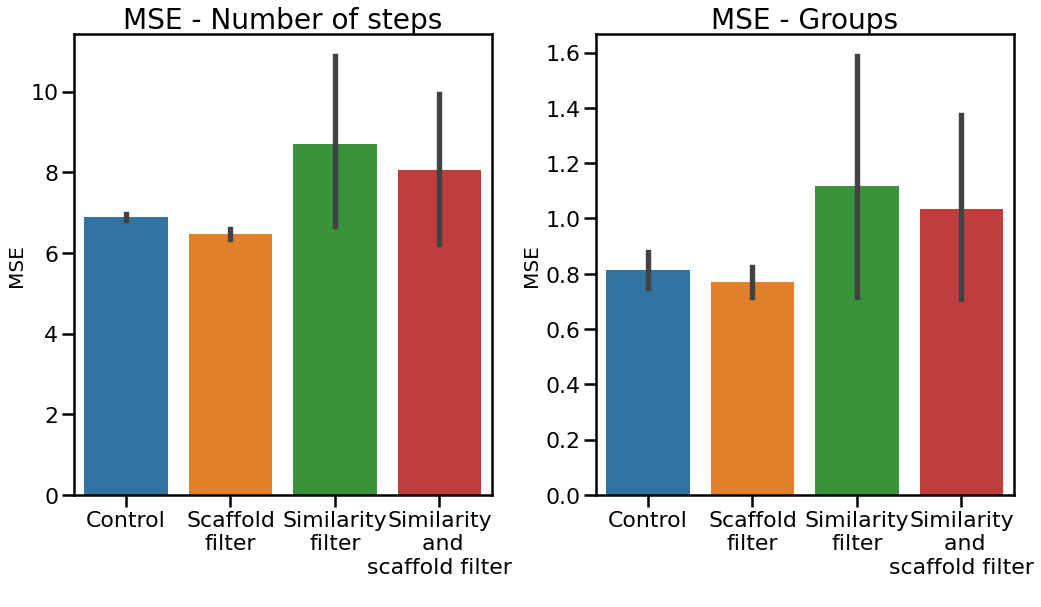

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.set_context("poster", rc={"font.size":18,"axes.titlesize":20,"axes.labelsize":18}) 
fig.tight_layout(pad=2.0)

sns.barplot(ax=axes[0], data=df_scores, x="data", y="test_MSE")
axes[0].set_title('MSE - Number of steps', fontsize=28)
sns.barplot(ax=axes[1], data=df_scores2, x="data", y="test_MSE")
axes[1].set_title('MSE - Groups', fontsize=28)

axes[0].set_ylabel('MSE',fontsize=20)
axes[0].set_xlabel(' ',fontsize=20)
axes[1].set_ylabel('MSE',fontsize=20)
axes[1].set_xlabel(' ',fontsize=20)

In [ ]:
fig.savefig('mse_filters_groups.png')

# Confusion matrix

In [102]:
def return_round_predict(model, X_train, y_train, X_test, limit):
    model_fit = model.fit(X_train, y_train)
    predict = model_fit.predict(X_test)
    predict_r = np.array([round(y) for y in predict])
    for i in range(len(predict_r)):
        if predict_r[i] > limit:
            predict_r[i] = limit
    return predict_r  

In [98]:
RFR = RandomForestRegressor(random_state=0)

## Steps

In [96]:
X_train, X_test, y_train, y_test = train_test_split(x, y_steps, random_state=1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(x_scaf, y_scaf_steps, random_state=1)

In [104]:
predict = return_round_predict(RFR, X_train, y_train, X_test, 9)
predict1 = return_round_predict(RFR, X_train1, y_train1, X_test1, 9)

Text(0.5, 1.0, 'Scaffold filter')

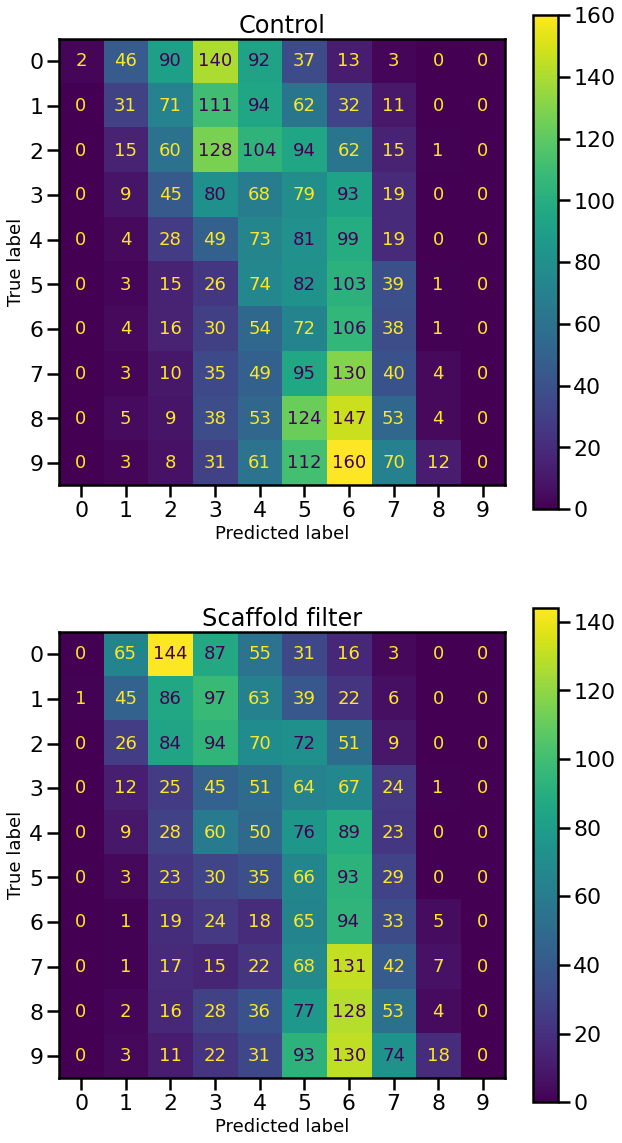

In [116]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,20))
#fig.delaxes(ax[1,2])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict)).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix(y_test1, predict1)).plot(ax=ax[1])
ax[0].set_title("Control", fontsize=24)
ax[1].set_title("Scaffold filter", fontsize=24)

Text(0.5, 1.0, 'Scaffold filter normalize')

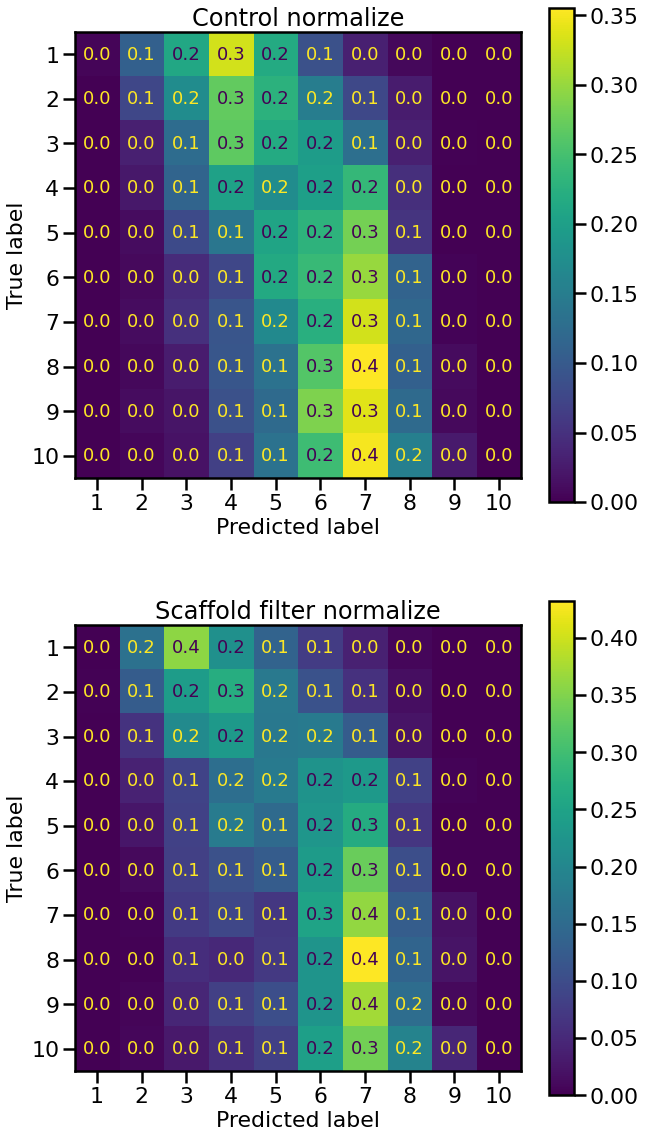

In [150]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,20))
ConfusionMatrixDisplay.from_predictions(y_test, predict, ax=ax[0], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test1, predict1, ax=ax[1], normalize = 'true', values_format='.1f')
ax[0].set_title("Control normalize", fontsize=24)
ax[1].set_title("Scaffold filter normalize", fontsize=24)

In [151]:
fig.savefig('confusion_matrix_filters.png')

## Groups

In [119]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, random_state=1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(x_scaf, y_scaf, random_state=1)

In [120]:
predict2 = return_round_predict(RFR, X_train2, y_train2, X_test2, 3)
predict3 = return_round_predict(RFR, X_train3, y_train3, X_test3, 3)

Text(0.5, 1.0, 'Scaffold filter normalize')

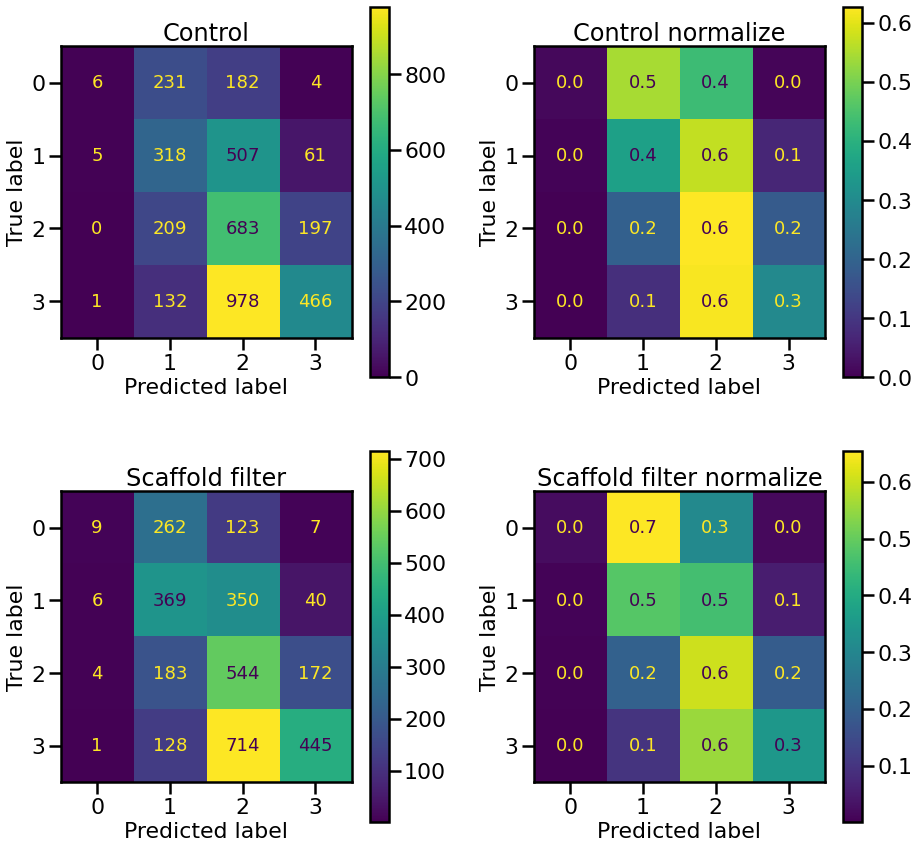

In [153]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
#fig.delaxes(ax[1,2])
plt.subplots_adjust(wspace = 0.3)
ConfusionMatrixDisplay(confusion_matrix(y_test2, predict2)).plot(ax=ax[0,0])
ConfusionMatrixDisplay.from_predictions(y_test2, predict2, ax=ax[0,1], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay(confusion_matrix(y_test3, predict3)).plot(ax=ax[1,0])
ConfusionMatrixDisplay.from_predictions(y_test3, predict3, ax=ax[1,1], normalize = 'true', values_format='.1f')
ax[0,0].set_title("Control", fontsize=24)
ax[1,0].set_title("Scaffold filter", fontsize=24)
ax[0,1].set_title("Control normalize", fontsize=24)
ax[1,1].set_title("Scaffold filter normalize", fontsize=24)

In [154]:
fig.savefig('confusion_matrix_filters_groups.png')